In [1]:
from typing import Tuple, Callable
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
class SprintRodsSystemSetup:

    def __init__(
            self,
            interval: Tuple[float, float],
            spring_len: float,
            nodes_num: int,
            material_constants: Tuple[float, float],
            spring_constants: Tuple[float, float],
            body_forces: Callable[[np.ndarray], np.ndarray]
    ):
        self.left_end, self.right_end = interval
        self.spring_len = spring_len
        self.half_spring_len = spring_len / 2
        self.nodes_num = nodes_num
        self.body_forces = body_forces

        self.left_domain = np.linspace(self.left_end, -self.half_spring_len, nodes_num)
        self.right_domain = np.linspace(self.half_spring_len, self.right_end, nodes_num)
        self.alphas = material_constants
        self.spring_constants = spring_constants

    def __call__(self, displacements: np.ndarray):
        return self.A(displacements) / 2 + self.j(displacements) - self.f(displacements)

    def A(self, displacements: np.ndarray):
        left_displ = displacements[:self.nodes_num]
        right_displ = displacements[self.nodes_num:]

        left = np.diff(left_displ) ** 2 / np.diff(self.left_domain)
        right = np.diff(right_displ) ** 2 / np.diff(self.right_domain)

        return self.alphas[0] * np.sum(left) + self.alphas[1] * np.sum(right)

    def j(self, displacements: np.ndarray):
        left_end_displ = displacements[self.nodes_num - 1]
        right_end_displ = displacements[self.nodes_num]
        return self.spring_constants[0] * (right_end_displ - left_end_displ) ** 2 / 2

    def f(self, displacements: np.ndarray):
        fun_vals = self.compute_body_forces()

        left_displ = displacements[:self.nodes_num]
        right_displ = displacements[self.nodes_num:]

        left = np.diff(self.left_domain) * (left_displ[1:] + left_displ[:-1]) / 2
        right = np.diff(self.right_domain) * (right_displ[1:] + right_displ[:-1]) / 2

        return np.sum(fun_vals * np.concatenate((left, right)))

    def compute_body_forces(self):
        left_centers = (self.left_domain[1:] + self.left_domain[:-1]) / 2
        right_centers = (self.right_domain[1:] + self.right_domain[:-1]) / 2
        centers = np.concatenate((left_centers, right_centers))
        return self.body_forces(centers)

In [3]:
model = SprintRodsSystemSetup(
    interval=(-1, 1),
    spring_len=1,
    nodes_num=10,
    material_constants=(1, 1),
    spring_constants=(1, 1),
    body_forces=lambda x: 1.
)

In [4]:
constraint = np.zeros(2 * model.nodes_num)
constraint[model.nodes_num - 1] = 1
constraint[model.nodes_num] = -1

prevent_penetration = optimize.LinearConstraint(A=constraint, lb=-np.inf, ub=model.spring_len)

In [5]:
lower_bounds = np.full(2 * model.nodes_num, fill_value=-np.inf)
lower_bounds[0] = 0
lower_bounds[-1] = 0

upper_bounds = np.full(2 * model.nodes_num, fill_value=np.inf)
upper_bounds[0] = 0
upper_bounds[-1] = 0

dirichlet_boundaries = optimize.Bounds(lower_bounds, upper_bounds)

In [6]:
result = optimize.minimize(fun=model, x0=np.zeros(2 * model.nodes_num), constraints=prevent_penetration, bounds=dirichlet_boundaries)
displacements = result.x

assert result.success
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.04153806584323924
       x: [ 0.000e+00  2.623e-02 ...  2.623e-02  0.000e+00]
     nit: 10
     jac: [       nan -3.083e-07 ... -3.073e-07        nan]
    nfev: 206
    njev: 10

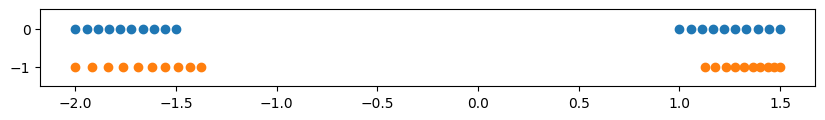

In [7]:
positions = np.concatenate((
    model.left_end + model.left_domain,
    model.half_spring_len + model.right_domain
))

fig = plt.gcf()
fig.set_size_inches(10, 1)
plt.ylim(-1.5, 0.5)
plt.scatter(x=positions, y=np.zeros(2 * model.nodes_num))
plt.scatter(x=positions + displacements, y=np.full(2 * model.nodes_num, fill_value=-1))

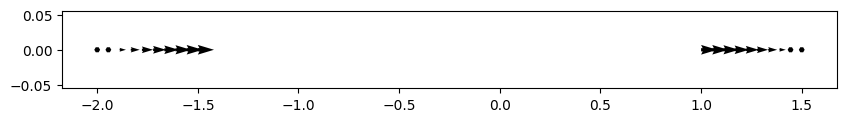

In [8]:
fig = plt.gcf()
fig.set_size_inches(10, 1)
plt.quiver(positions, np.zeros_like(positions), displacements, np.zeros_like(displacements), scale=6)